# Combined Regression Analysis

Group together ECT and MST data, use changes in spectral features (no colinearities) to predict clinical outcome


HAMD_ratio ~ treatment_type(discrete) + n_sessions(discrete) + d_exponent  + d_theta_osc_perc  
HAMD_diff ~ treatment_type(discrete) + n_sessions(discreet) + d_exponent + d_theta_osc_perc

For ECT - one figure showing one patient with EMERGENCE of delta/theta oscillations

plot correlations with residuals, not just raw data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm
from pingouin import ttest, corr

from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'
#from plotting_functions import plot_feature_prepost

In [2]:
ECT_path = './saved_files/ect_files/ect_clin_eeg_diff.csv'
MST_path = './saved_files/mst_files/mst_clin_eeg_diff.csv'

In [3]:
def plot_feature_prepost(exp_df_mean, feature='', tx_type=''):
    """Creates a plot of a given feature from the dataframe,
       comparing its value before and after treatment

    Parameters
    ----------
    exp_df_mean: pandas DataFrame
        dataframe containing extractec features, averaged across electrodes
    feature: str
        feature of interest; 'alphas', 'thetas', 'chans_exps'
    tx_type: str
        treatment type (to determine color scheme); 'ECT', 'MST'

    Returns
    -------
    plot: matplotlib obj
        plot of feature pre/post treatment
    """
    
    pats = np.unique(exp_df_mean['patient'])
    
    if tx_type=='ECT':
        pre_color = 'orange'
        post_color = 'teal'
    elif tx_type=='MST':
        pre_color = 'royalblue'
        post_color = 'salmon'

    # means of alphas across patient, channels
    means_pre = exp_df_mean['HAMD_TotalPre'].values
    means_post = exp_df_mean['HAMD_TotalPost'].values

    sns.set_context('poster')

    plt.figure(figsize=(5,8))
    x1, x2 = 0.5, 1.5

    for pat in pats:

        point_pre = exp_df_mean[(exp_df_mean['patient']==pat)]['HAMD_TotalPre'].values
        point_post = exp_df_mean[(exp_df_mean['patient']==pat)]['HAMD_TotalPost'].values
        xdat1= x1+np.random.normal(0, 0.025, 1)
        xdat2= x2+np.random.normal(0, 0.025, 1)


        plt.plot([xdat1,xdat2], [point_pre, point_post], color='k', alpha=0.05, lw=5)
        plt.scatter(xdat1, point_pre, color=pre_color, alpha=0.7)
        plt.scatter(xdat2, point_post, color=post_color, alpha=0.7)

    plt.plot([x1-0.2, x1+0.2], [np.nanmean(means_pre), np.nanmean(means_pre)], lw=7, c=pre_color)
    plt.plot([x2-0.2, x2+0.2], [np.nanmean(means_post), np.nanmean(means_post)], lw=7, c=post_color)
            
    plt.xlim([0, 2])

    plt.xticks([x1, x2], ["pre", "post"])

#     if feature == 'alphas':
#         ylabel = 'Alpha Frequency (Hz)'
#     elif feature == 'thetas':
#         ylabel = 'Theta Frequency (Hz)'
#     elif feature == 'chans_exps':
#         ylabel = 'Aperiodic Exponent'
#     else:
#         ylabel = feature[:5]+' power'

#     plt.ylabel(ylabel)

    plt.tight_layout()


In [4]:
sns.set_context('paper')

# next time

in other notebook:
- add N_tx_recieved column

in THIS notebook

- load clin_eeg_diff csvs for MST and ECT
- rename patient columns so no overlapping patient IDs
- merge
- run regressions on combined dataframe


# 1. load dataframes

For ECT and MST datasets, load dataframes containing clinical ratings (incl. differences and ratios) and EEG features DIFFERENCES (post-pre) after recieving each treatment. EEG features are averaged across frontal and central electrodes, as those cortical regions are though to be the target of treatment and likely to express physiological changes following treatment (Smith et al 2022).

In [5]:
ECT_clin_eeg_diff = pd.read_csv(ECT_path)
MST_clin_eeg_diff = pd.read_csv(MST_path)

In [6]:
ECT_clin_eeg_diff

,Unnamed: 0,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,...,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc
0,0,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,...,0.119949,0.477515,-0.285887,0.295405,1.404048,1.075006,2.0,0.066667,15.0,0.500000
1,1,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,...,-0.987794,-0.553460,-0.419882,-0.745405,-0.160082,0.270590,1.0,0.033333,19.0,0.633333
2,2,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,...,-1.964052,2.045941,0.218302,0.726111,0.718286,0.418527,-1.0,-0.033333,6.0,0.200000
3,3,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,...,0.098229,0.357956,-0.049624,0.097556,0.180340,0.136796,-0.0,-0.000000,-0.0,-0.000000
4,4,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,...,-1.364629,2.735535,-0.131871,0.249225,0.829674,0.575351,-0.0,-0.000000,16.0,0.533333
5,5,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,...,-0.962770,2.960272,0.236376,0.592996,0.731502,0.558976,-0.0,-0.000000,5.0,0.166667
6,6,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,...,-1.252760,0.652010,-1.007062,0.051420,0.518482,-0.092380,2.0,0.153846,2.0,0.153846
7,7,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.259569,3.922416,-0.252168,1.110192,1.536740,0.718005,4.0,0.142857,20.0,0.714286
8,8,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.283428,3.014095,0.280315,1.173071,1.347373,0.561628,7.0,0.233333,-12.0,-0.400000
9,9,31,23.0,9.0,31.0,10.0,17.0,14.0,0.608696,21.0,...,-0.474782,2.129068,-0.924921,-0.121469,1.188699,0.770159,21.0,0.700000,5.0,0.166667


In [7]:
MST_clin_eeg_diff

,Unnamed: 0,patient,HAMD_TotalPre,HAMD_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,delta_cf,delta_bw,delta_amp,...,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc
0,0,9,23,19.0,24,4.0,0.173913,NaN,NaN,NaN,...,0.052195,-2.006618,0.065636,-0.283744,-0.478052,-0.276041,-0.0,-0.000000,16.0,0.761905
1,1,10,28,NaN,18,NaN,NaN,NaN,NaN,NaN,...,-0.243771,-1.726277,-0.071534,-0.402487,-0.348899,-0.072895,2.0,0.111111,-0.0,-0.000000
2,2,18,24,27.0,24,-3.0,-0.125000,NaN,NaN,NaN,...,0.645699,-0.189001,-0.098326,-0.133016,-0.175104,-0.121509,-0.0,-0.000000,-8.0,-0.380952
3,3,22,22,NaN,6,NaN,NaN,NaN,NaN,NaN,...,-0.836061,1.578279,0.483526,0.933224,0.947842,0.585788,-0.0,-0.000000,-18.0,-0.857143
4,4,25,34,NaN,21,NaN,NaN,NaN,NaN,NaN,...,0.779126,0.601159,0.808540,0.274807,-0.445921,0.027925,-0.0,-0.000000,1.0,0.047619
5,5,33,26,19.0,24,7.0,0.269231,NaN,NaN,NaN,...,0.030391,-0.519362,-0.120991,0.005346,0.590935,0.525964,-0.0,-0.000000,6.0,0.285714
6,6,35,29,NaN,6,NaN,NaN,NaN,NaN,NaN,...,0.511934,-1.948318,-0.276545,-0.301135,-0.067820,0.015692,3.0,0.142857,19.0,0.904762
7,7,40,24,11.0,24,13.0,0.541667,NaN,NaN,NaN,...,0.072597,0.265953,0.145740,0.199701,0.338751,0.243568,-0.0,-0.000000,-0.0,-0.000000
8,8,46,29,21.0,24,8.0,0.275862,NaN,NaN,NaN,...,0.053991,0.043386,-0.045084,-0.144225,-0.081668,0.037022,-0.0,-0.000000,13.0,0.619048
9,9,47,41,31.0,24,10.0,0.243902,-2.143993,1.213764,0.027656,...,0.663765,-0.865775,0.307139,-0.089466,-0.330299,-0.216145,-0.0,-0.000000,-0.0,-0.000000


# 2. Rename patient IDs

patients in the MST and ECT datasets have similar ID numbers. Here, we rename them to their TX_ID# (ex. ECT_1, or MST_22)

In [8]:
MST_new_ids = []

for pat_id in MST_clin_eeg_diff['patient'].values:
    new_id = 'MST_'+str(pat_id)
    MST_new_ids.append(new_id)

In [9]:
ECT_new_ids = []

for pat_id in ECT_clin_eeg_diff['patient'].values:
    new_id = 'ECT_'+str(pat_id)
    ECT_new_ids.append(new_id)

In [10]:
ECT_clin_eeg_diff['new_patientID'] = ECT_new_ids
MST_clin_eeg_diff['new_patientID'] = MST_new_ids

# 3. Merge ECT and MST dataframes

In [11]:
len(MST_clin_eeg_diff['patient'])

23

In [12]:
# Add column for treatment type
MST_clin_eeg_diff['treatment_type'] = np.tile('MST', len(MST_clin_eeg_diff['patient']))
ECT_clin_eeg_diff['treatment_type'] = np.tile('ECT', len(ECT_clin_eeg_diff['patient']))

In [13]:
ECT_MST_clin_eeg_diff = pd.concat([ECT_clin_eeg_diff, MST_clin_eeg_diff])

In [14]:
ECT_MST_clin_eeg_diff.columns

Index(['Unnamed: 0', 'patient', 'HAMD_TotalPre', 'HAMD_TotalPost',
       'MADRS_TotalPre', 'MADRS_TotalPost', 'n_TxsReceived', 'HAMD_diff',
       'HAMD_ratio', 'MADRS_diff', 'MADRS_ratio', 'delta_cf', 'delta_bw',
       'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
       'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset',
       'exponent', 'delta_present', 'ch_delta_perc', 'theta_present',
       'ch_theta_perc', 'new_patientID', 'treatment_type'],
      dtype='object')

In [15]:
ECT_MST_clin_eeg_diff

,Unnamed: 0,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,...,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc,new_patientID,treatment_type
0,0,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,...,-0.285887,0.295405,1.404048,1.075006,2.0,0.066667,15.0,0.500000,ECT_3,ECT
1,1,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,...,-0.419882,-0.745405,-0.160082,0.270590,1.0,0.033333,19.0,0.633333,ECT_4,ECT
2,2,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,...,0.218302,0.726111,0.718286,0.418527,-1.0,-0.033333,6.0,0.200000,ECT_10,ECT
3,3,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,...,-0.049624,0.097556,0.180340,0.136796,-0.0,-0.000000,-0.0,-0.000000,ECT_13,ECT
4,4,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,...,-0.131871,0.249225,0.829674,0.575351,-0.0,-0.000000,16.0,0.533333,ECT_16,ECT
5,5,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,...,0.236376,0.592996,0.731502,0.558976,-0.0,-0.000000,5.0,0.166667,ECT_18,ECT
6,6,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,...,-1.007062,0.051420,0.518482,-0.092380,2.0,0.153846,2.0,0.153846,ECT_19,ECT
7,7,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.252168,1.110192,1.536740,0.718005,4.0,0.142857,20.0,0.714286,ECT_25,ECT
8,8,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.280315,1.173071,1.347373,0.561628,7.0,0.233333,-12.0,-0.400000,ECT_29,ECT
9,9,31,23.0,9.0,31.0,10.0,17.0,14.0,0.608696,21.0,...,-0.924921,-0.121469,1.188699,0.770159,21.0,0.700000,5.0,0.166667,ECT_31,ECT


In [16]:
ECT_clin_eeg_diff['HAMD_TotalPost'].shape

(22,)

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


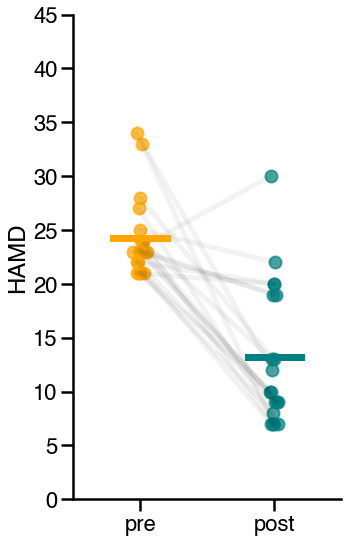

In [17]:
plot_feature_prepost(ECT_clin_eeg_diff, feature='HAMD_TotalPre', tx_type='ECT')
plt.ylabel('HAMD');
plt.ylim([0,45])
sns.despine()

In [18]:
ttest(x=ECT_clin_eeg_diff['HAMD_TotalPre'], y=ECT_clin_eeg_diff['HAMD_TotalPost'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.93785,18,two-sided,0.000013,"[7.14, 14.96]",2.065479,1766.477,1.0


In [19]:
print('pre = '+ str(ECT_clin_eeg_diff[ECT_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPre'].mean()))
print('post = '+ str(ECT_clin_eeg_diff[ECT_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPost'].mean()))

pre = 24.263157894736842
post = 13.210526315789474


In [20]:
ttest(x=MST_clin_eeg_diff['HAMD_TotalPre'], y=MST_clin_eeg_diff['HAMD_TotalPost'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.142088,14,two-sided,0.000997,"[3.25, 10.22]",0.925102,38.814,0.914382


In [21]:
print('pre = '+ str(MST_clin_eeg_diff[MST_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPre'].mean()))
print('post = '+ str(MST_clin_eeg_diff[MST_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPost'].mean()))

pre = 28.133333333333333
post = 21.4


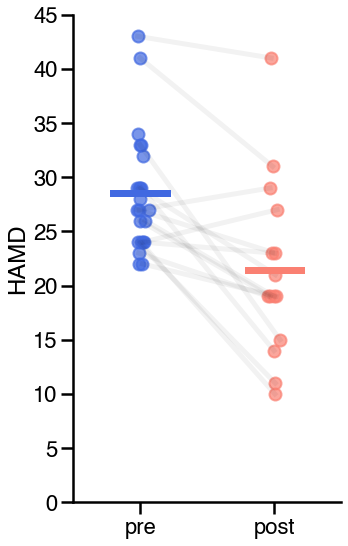

In [22]:
plot_feature_prepost(MST_clin_eeg_diff, feature='HAMD_TotalPre', tx_type='MST')
plt.ylabel('HAMD');
plt.ylim([0,45])
sns.despine()

In [23]:
ttest(ECT_clin_eeg_diff['HAMD_ratio'], MST_clin_eeg_diff['HAMD_ratio'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.233514,31.967316,two-sided,0.03264,"[0.02, 0.38]",0.746655,2.107,0.554369


In [24]:
ECT_clin_eeg_diff.columns

Index(['Unnamed: 0', 'patient', 'HAMD_TotalPre', 'HAMD_TotalPost',
       'MADRS_TotalPre', 'MADRS_TotalPost', 'n_TxsReceived', 'HAMD_diff',
       'HAMD_ratio', 'MADRS_diff', 'MADRS_ratio', 'delta_cf', 'delta_bw',
       'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
       'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset',
       'exponent', 'delta_present', 'ch_delta_perc', 'theta_present',
       'ch_theta_perc', 'new_patientID', 'treatment_type'],
      dtype='object')

In [25]:
print('ect = ' + str(ECT_clin_eeg_diff['HAMD_TotalPost'].mean()))
print('ect std = ' + str(ECT_clin_eeg_diff['HAMD_TotalPost'].std()))
print('mst = ' + str(MST_clin_eeg_diff['HAMD_TotalPost'].mean()))
print('mst std = ' + str(MST_clin_eeg_diff['HAMD_TotalPost'].std()))

ect = 13.210526315789474
ect std = 6.562341616022448
mst = 21.4
mst std = 8.139849068449786


In [26]:
2022-80

1942

# 4. Multiple Linear Regression

HAMD_ratio ~ treatment_type(discrete) + n_sessions(discrete) + d_exponent  + d_theta_osc_perc  
HAMD_diff ~ treatment_type(discrete) + n_sessions(discreet) + d_exponent + d_theta_osc_perc

In [27]:
sns.set_context('paper')

In [28]:
ECT_MST_clin_eeg_diff['HAMD_ratio'].mean(skipna=True)

0.3516634799917243

In [29]:
formula = 'HAMD_ratio ~ C(treatment_type) + n_TxsReceived + exponent + ch_theta_perc + exponent:n_TxsReceived'

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1.792
Date:                Fri, 09 Dec 2022   Prob (F-statistic):              0.148
Time:                        14:47:35   Log-Likelihood:              -0.037124
No. Observations:                  33   AIC:                             12.07
Df Residuals:                      27   BIC:                             21.05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

eval_env: 1


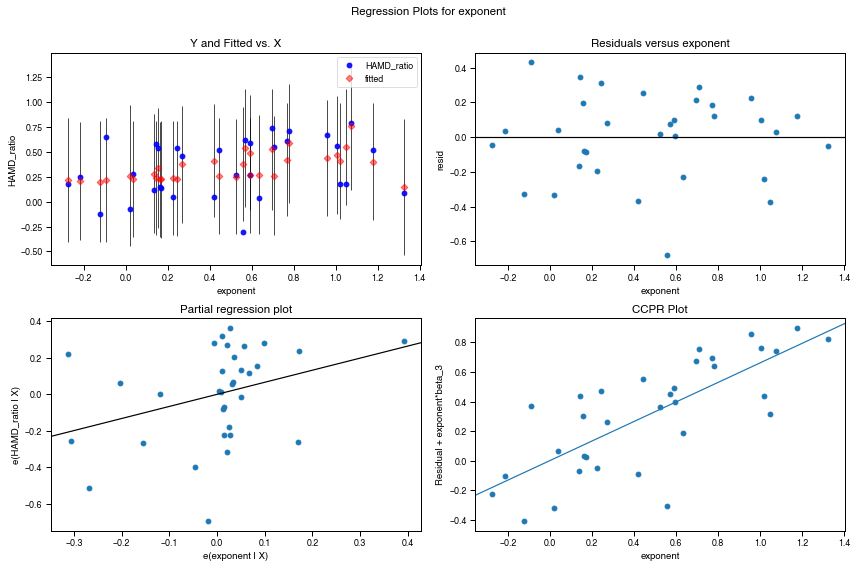

In [30]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'exponent', fig=fig)

# This is the one i used in the paper!!!

In [31]:
formula = 'HAMD_ratio ~ exponent:n_TxsReceived + exponent + ch_theta_perc '

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     3.184
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0385
Time:                        14:47:35   Log-Likelihood:              -0.067293
No. Observations:                  33   AIC:                             8.135
Df Residuals:                      29   BIC:                             14.12
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

eval_env: 1


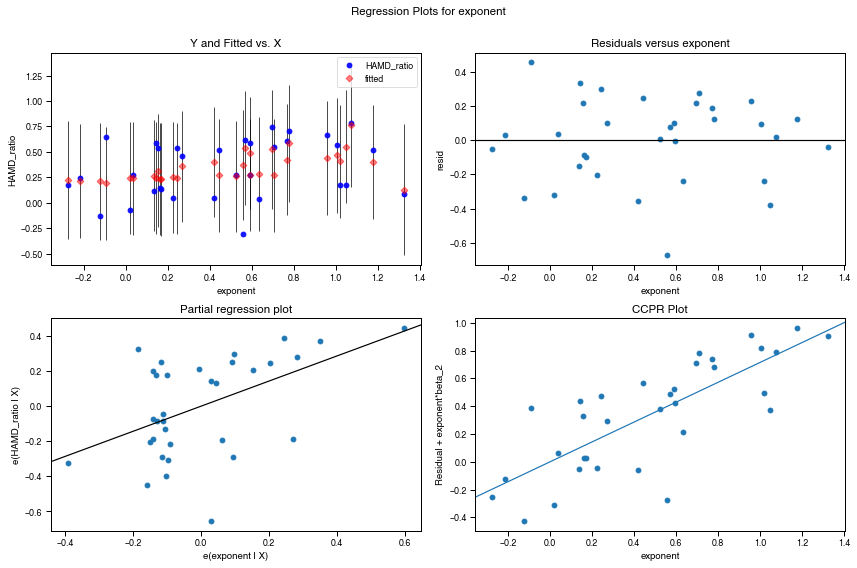

In [32]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'exponent', fig=fig)

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

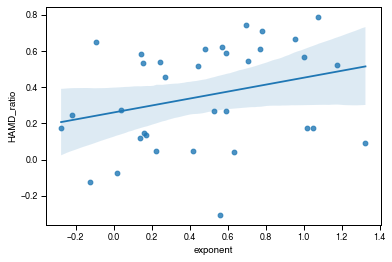

In [33]:
sns.regplot(ECT_MST_clin_eeg_diff['exponent'], ECT_MST_clin_eeg_diff['HAMD_ratio'])

In [34]:
corr(ECT_MST_clin_eeg_diff['exponent'], ECT_MST_clin_eeg_diff['HAMD_ratio'])

,n,r,CI95%,p-val,BF10,power
pearson,34,0.28587,"[-0.06, 0.57]",0.101223,0.774,0.381284


/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_diff'>

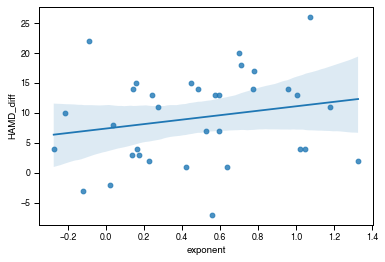

In [35]:
sns.regplot(ECT_MST_clin_eeg_diff['exponent'], ECT_MST_clin_eeg_diff['HAMD_diff'])

In [36]:
corr(ECT_MST_clin_eeg_diff['exponent'], ECT_MST_clin_eeg_diff['HAMD_diff'])

,n,r,CI95%,p-val,BF10,power
pearson,34,0.206548,"[-0.14, 0.51]",0.241191,0.413,0.218619


In [37]:
formula = 'HAMD_diff ~ exponent + ch_theta_perc + exponent:n_TxsReceived'

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

# Pre-treatment EEG measures as predictors for treatment response

                            OLS Regression Results                            
Dep. Variable:              HAMD_diff   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     2.450
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0836
Time:                        14:47:36   Log-Likelihood:                -109.73
No. Observations:                  33   AIC:                             227.5
Df Residuals:                      29   BIC:                             233.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

In [38]:
formula = 'HAMD_ratio ~ exponent + exponent:n_TxsReceived'


model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     4.924
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0142
Time:                        14:47:36   Log-Likelihood:              -0.081202
No. Observations:                  33   AIC:                             6.162
Df Residuals:                      30   BIC:                             10.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [39]:
formula = 'HAMD_ratio ~ exponent + ch_theta_perc + exponent:n_TxsReceived'


model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     3.184
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0385
Time:                        14:47:36   Log-Likelihood:              -0.067293
No. Observations:                  33   AIC:                             8.135
Df Residuals:                      29   BIC:                             14.12
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

eval_env: 1


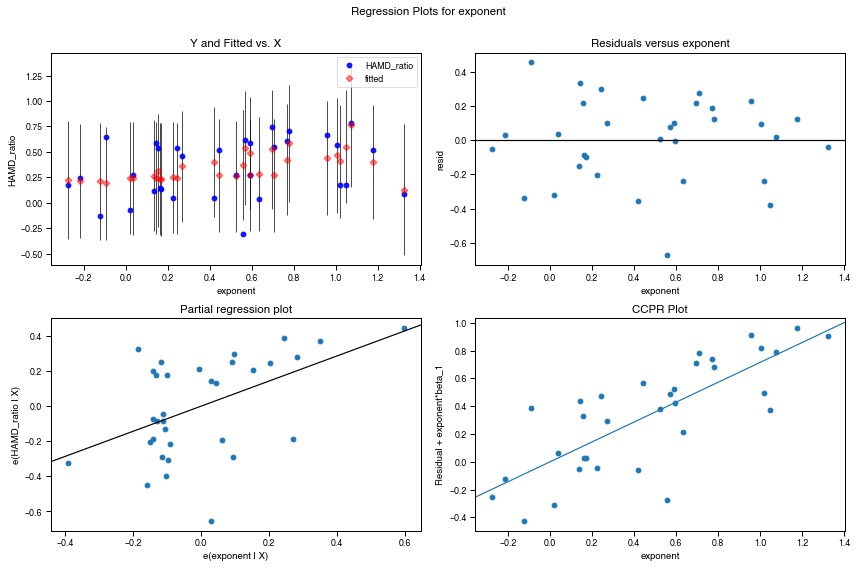

In [40]:
fig = plt.figure(figsize=(12,8))
sns.set_context('paper')

fig = sm.graphics.plot_regress_exog(model, 'exponent', fig=fig)

In [41]:
# determine % of MST sample that got 24 (max) treatments

ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['n_TxsReceived']==24]

,Unnamed: 0,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,...,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc,new_patientID,treatment_type
0,0,9,23.0,19.0,NaN,NaN,24.0,4.0,0.173913,NaN,...,0.065636,-0.283744,-0.478052,-0.276041,-0.0,-0.0,16.0,0.761905,MST_9,MST
2,2,18,24.0,27.0,NaN,NaN,24.0,-3.0,-0.125000,NaN,...,-0.098326,-0.133016,-0.175104,-0.121509,-0.0,-0.0,-8.0,-0.380952,MST_18,MST
5,5,33,26.0,19.0,NaN,NaN,24.0,7.0,0.269231,NaN,...,-0.120991,0.005346,0.590935,0.525964,-0.0,-0.0,6.0,0.285714,MST_33,MST
7,7,40,24.0,11.0,NaN,NaN,24.0,13.0,0.541667,NaN,...,0.145740,0.199701,0.338751,0.243568,-0.0,-0.0,-0.0,-0.000000,MST_40,MST
8,8,46,29.0,21.0,NaN,NaN,24.0,8.0,0.275862,NaN,...,-0.045084,-0.144225,-0.081668,0.037022,-0.0,-0.0,13.0,0.619048,MST_46,MST
9,9,47,41.0,31.0,NaN,NaN,24.0,10.0,0.243902,NaN,...,0.307139,-0.089466,-0.330299,-0.216145,-0.0,-0.0,-0.0,-0.000000,MST_47,MST
11,11,66,26.0,19.0,NaN,NaN,24.0,7.0,0.269231,NaN,...,-0.442349,0.222649,1.046004,0.592998,-0.0,-0.0,14.0,0.666667,MST_66,MST
12,12,69,24.0,23.0,NaN,NaN,24.0,1.0,0.041667,NaN,...,-0.778350,-0.384286,0.691359,0.634209,-0.0,-0.0,21.0,1.000000,MST_69,MST
13,13,95,33.0,15.0,NaN,NaN,24.0,18.0,0.545455,NaN,...,-0.077269,0.293831,0.951922,0.707386,-0.0,-0.0,4.0,0.190476,MST_95,MST
18,18,130,24.0,10.0,NaN,NaN,24.0,14.0,0.583333,NaN,...,0.314666,0.312283,0.158489,0.142979,-0.0,-0.0,11.0,0.550000,MST_130,MST


In [42]:
14/23

0.6086956521739131

In [43]:
# re-run regresion excluding MST participants that maxed out treatment (!=24)
formula = 'HAMD_ratio ~ exponent + ch_theta_perc + exponent:n_TxsReceived + C(treatment_type) + n_TxsReceived:treatment_type'

no24_df = pd.DataFrame(ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['n_TxsReceived']!=24]).reset_index()


model = ols(formula, no24_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     2.124
Date:                Fri, 09 Dec 2022   Prob (F-statistic):              0.127
Time:                        14:47:36   Log-Likelihood:                 1.0645
No. Observations:                  19   AIC:                             9.871
Df Residuals:                      13   BIC:                             15.54
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [44]:
# investigate the interaction between exponent and n_TxsRecieved

sherlock_df = pd.DataFrame(ECT_MST_clin_eeg_diff[['HAMD_ratio', 'n_TxsReceived', 'exponent', 'treatment_type']])

In [45]:
sherlock_df_filt = sherlock_df[~sherlock_df['HAMD_ratio'].isna()]

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_TxsReceived', ylabel='exponent'>

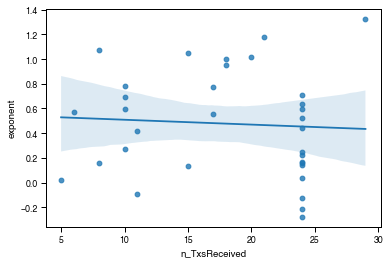

In [46]:
sns.regplot(sherlock_df_filt['n_TxsReceived'], sherlock_df_filt['exponent'])

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_TxsReceived', ylabel='exponent'>

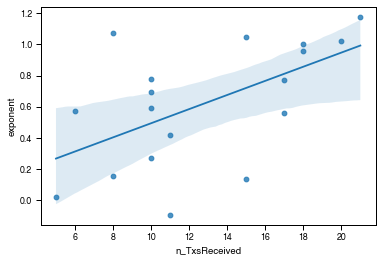

In [47]:
sns.regplot(sherlock_df_filt[sherlock_df_filt['n_TxsReceived']<24]['n_TxsReceived'],
            sherlock_df_filt[sherlock_df_filt['n_TxsReceived']<24]['exponent'])

In [48]:
corr(sherlock_df_filt[sherlock_df_filt['n_TxsReceived']<24]['n_TxsReceived'],
            sherlock_df_filt[sherlock_df_filt['n_TxsReceived']<24]['exponent'])

,n,r,CI95%,p-val,BF10,power
pearson,18,0.562022,"[0.13, 0.82]",0.015202,4.478,0.71208


In [49]:
formula = 'HAMD_ratio ~ n_TxsReceived + C(treatment_type) + exponent + ch_theta_perc + exponent:n_TxsReceived'


model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1.792
Date:                Fri, 09 Dec 2022   Prob (F-statistic):              0.148
Time:                        14:47:37   Log-Likelihood:              -0.037124
No. Observations:                  33   AIC:                             12.07
Df Residuals:                      27   BIC:                             21.05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

eval_env: 1


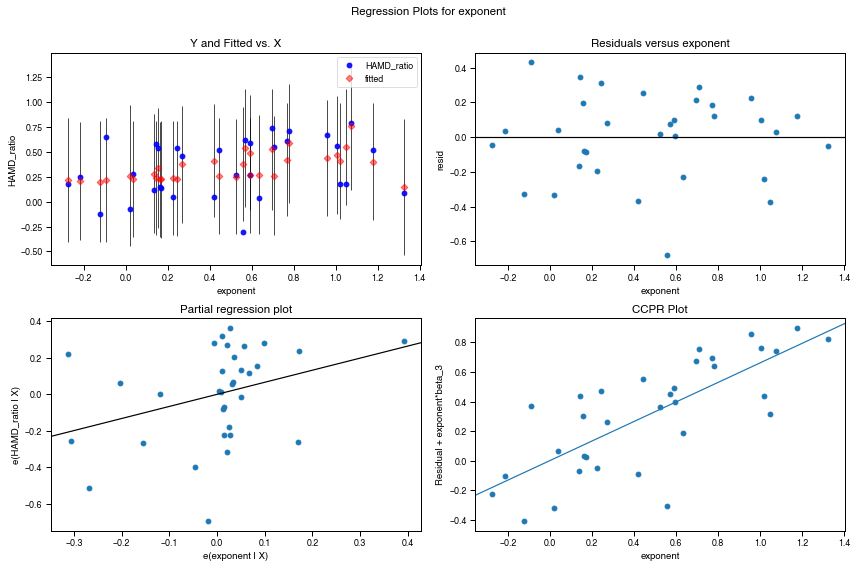

In [50]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'exponent', fig=fig)

In [51]:
formula = 'HAMD_ratio ~ C(treatment_type) + exponent + ch_theta_perc + exponent:n_TxsReceived'


model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     2.320
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0815
Time:                        14:47:37   Log-Likelihood:              -0.041520
No. Observations:                  33   AIC:                             10.08
Df Residuals:                      28   BIC:                             17.57
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [52]:
formula = 'HAMD_ratio ~ exponent + n_TxsReceived + C(treatment_type) + exponent:n_TxsReceived + n_TxsReceived:C(treatment_type)'

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     3.305
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0186
Time:                        14:47:37   Log-Likelihood:                 3.1130
No. Observations:                  33   AIC:                             5.774
Df Residuals:                      27   BIC:                             14.75
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

# Pre-treatment EEG measures regression

In [53]:
ECT_path_pre = './saved_files/ect_files/ect_clin_eeg_pre.csv'
MST_path_pre = './saved_files/mst_files/mst_clin_eeg_pre.csv'

In [54]:
ECT_clin_eeg_pre = pd.read_csv(ECT_path_pre)
MST_clin_eeg_pre = pd.read_csv(MST_path_pre)

In [55]:
# Add column for treatment type
MST_clin_eeg_pre['treatment_type'] = np.tile('MST', len(MST_clin_eeg_pre['patient']))
ECT_clin_eeg_pre['treatment_type'] = np.tile('ECT', len(ECT_clin_eeg_pre['patient']))

In [56]:
MST_clin_eeg_pre.columns

Index(['Unnamed: 0', 'patient', 'HAMD_TotalPre', 'HAMD_TotalPost',
       'n_TxsReceived', 'HAMD_diff', 'HAMD_ratio', 'pre_post', 'delta_cf',
       'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw',
       'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp',
       'alpha_bp', 'offset', 'exponent', 'delta_present', 'ch_delta_perc',
       'theta_present', 'ch_theta_perc', 'treatment_type'],
      dtype='object')

In [57]:
ECT_MST_clin_eeg_pre = pd.concat([ECT_clin_eeg_pre, MST_clin_eeg_pre])

In [58]:
formula = 'HAMD_ratio ~ exponent + C(treatment_type) '

model = ols(formula, ECT_MST_clin_eeg_pre).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     4.051
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0273
Time:                        14:47:37   Log-Likelihood:               -0.89720
No. Observations:                  34   AIC:                             7.794
Df Residuals:                      31   BIC:                             12.37
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [59]:
ECT_MST_clin_eeg_pre

,Unnamed: 0,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,...,alpha_bw,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc,treatment_type
0,0,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,...,1.897472,0.660940,-11.909060,-12.011401,0.355315,0,0.000000,13,0.619048,ECT
1,1,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,...,2.258704,1.391490,-11.343510,-11.537213,0.792634,0,0.000000,0,0.000000,ECT
2,2,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,...,1.376570,1.154333,-11.881234,-11.675087,0.937748,0,0.000000,16,0.761905,ECT
3,3,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,...,1.314040,1.314050,-11.700679,-11.548660,1.062138,0,0.000000,0,0.000000,ECT
4,4,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,...,2.800016,0.863616,-11.689698,-11.622597,0.811229,0,0.000000,5,0.238095,ECT
5,5,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,...,1.743682,0.338069,-12.312198,-11.728670,0.827266,0,0.000000,0,0.000000,ECT
6,6,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,...,1.384618,1.688968,-12.136853,-12.255622,0.808271,0,0.000000,0,0.000000,ECT
7,7,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.261532,0.466347,-12.606898,-12.202817,0.601163,0,0.000000,0,0.000000,ECT
8,8,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.774282,0.238594,-12.893384,-11.728416,1.359698,15,0.714286,12,0.571429,ECT
9,9,31,23.0,9.0,31.0,10.0,17.0,14.0,0.608696,21.0,...,2.234335,1.860850,-10.687733,-10.701780,1.396638,0,0.000000,15,0.714286,ECT


In [60]:
corr(ECT_MST_clin_eeg_pre['exponent'], ECT_MST_clin_eeg_pre['HAMD_ratio'], method='spearman')

,n,r,CI95%,p-val,power
spearman,34,-0.355396,"[-0.62, -0.02]",0.039144,0.553766


/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

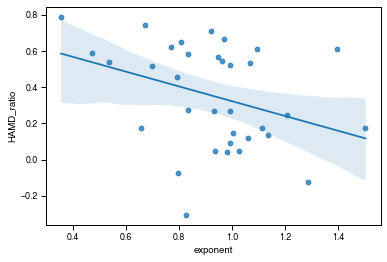

In [61]:
sns.regplot(ECT_MST_clin_eeg_pre['exponent'], ECT_MST_clin_eeg_pre['HAMD_ratio'])

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

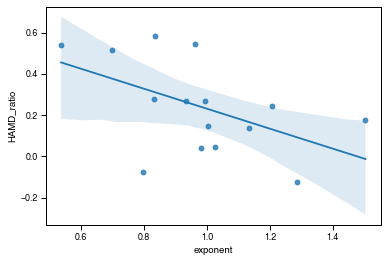

In [62]:
sns.regplot(MST_clin_eeg_pre['exponent'], 
            MST_clin_eeg_pre['HAMD_ratio'])

In [63]:
ECT_clin_eeg_pre

,Unnamed: 0,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,...,alpha_bw,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc,treatment_type
0,0,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,...,1.897472,0.660940,-11.909060,-12.011401,0.355315,0,0.000000,13,0.619048,ECT
1,1,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,...,2.258704,1.391490,-11.343510,-11.537213,0.792634,0,0.000000,0,0.000000,ECT
2,2,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,...,1.376570,1.154333,-11.881234,-11.675087,0.937748,0,0.000000,16,0.761905,ECT
3,3,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,...,1.314040,1.314050,-11.700679,-11.548660,1.062138,0,0.000000,0,0.000000,ECT
4,4,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,...,2.800016,0.863616,-11.689698,-11.622597,0.811229,0,0.000000,5,0.238095,ECT
5,5,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,...,1.743682,0.338069,-12.312198,-11.728670,0.827266,0,0.000000,0,0.000000,ECT
6,6,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,...,1.384618,1.688968,-12.136853,-12.255622,0.808271,0,0.000000,0,0.000000,ECT
7,7,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.261532,0.466347,-12.606898,-12.202817,0.601163,0,0.000000,0,0.000000,ECT
8,8,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.774282,0.238594,-12.893384,-11.728416,1.359698,15,0.714286,12,0.571429,ECT
9,9,31,23.0,9.0,31.0,10.0,17.0,14.0,0.608696,21.0,...,2.234335,1.860850,-10.687733,-10.701780,1.396638,0,0.000000,15,0.714286,ECT


/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '$\\Delta$ exponent')

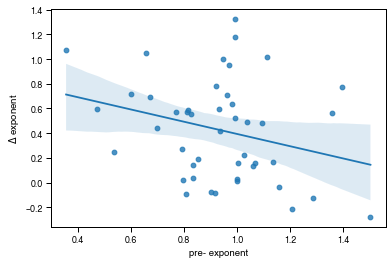

In [64]:
sns.regplot(ECT_MST_clin_eeg_pre['exponent'], ECT_MST_clin_eeg_diff['exponent'])
plt.xlabel('pre- exponent')
plt.ylabel('$\Delta$ exponent')

In [65]:
corr(ECT_MST_clin_eeg_pre['exponent'], ECT_MST_clin_eeg_diff['exponent'], method='spearman')

,n,r,CI95%,p-val,power
spearman,45,-0.267589,"[-0.52, 0.03]",0.075553,0.43424


# Baseline + change regression

In [66]:
ect_mst_pre_diff_clin = pd.DataFrame()
ect_mst_pre_diff_clin['patient'] = ECT_MST_clin_eeg_diff['patient']
ect_mst_pre_diff_clin['pre_exponent'] = ECT_MST_clin_eeg_pre['exponent']
ect_mst_pre_diff_clin['d_exponent'] = ECT_MST_clin_eeg_diff['exponent']
ect_mst_pre_diff_clin['HAMD_ratio'] = ECT_MST_clin_eeg_diff['HAMD_ratio']

In [67]:
ect_mst_pre_diff_clin

,patient,pre_exponent,d_exponent,HAMD_ratio
0,3,0.355315,1.075006,0.787879
1,4,0.792634,0.270590,0.458333
2,10,0.937748,0.418527,0.047619
3,13,1.062138,0.136796,0.120000
4,16,0.811229,0.575351,NaN
5,18,0.827266,0.558976,-0.304348
6,19,0.808271,-0.092380,0.647059
7,25,0.601163,0.718005,NaN
8,29,1.359698,0.561628,NaN
9,31,1.396638,0.770159,0.608696


In [68]:
formula = 'HAMD_ratio ~ pre_exponent + d_exponent'

model = ols(formula, ect_mst_pre_diff_clin).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     2.925
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0686
Time:                        14:47:38   Log-Likelihood:                -1.9055
No. Observations:                  34   AIC:                             9.811
Df Residuals:                      31   BIC:                             14.39
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6021      0.215      2.803   

# Syd's thoughts on the replication problem:

How do we reconcile the contradictory clinical findings in the longitudinal ECT paper and the ECT/MST study?

**The problem**

The longitudinal ECT study, hereby referred to as ECT_long, found that the increase in aperiodic exponent was *inversely* related to the decrease in clinical symptom severity as measured by the QIDS-SR. It also found that *larger* values of baseline aperiodic exponent were related to *greater* symptom improvement, indicating that patients who start treatment with more aperiodic activity might be more responsive to treatment. However, in the ECT/MST study, we found the opposite relationship in both of these effects. Specifically, the increase in aperiodic exponent was *directly* related to the magnitude of the relative improvement in clinical symptom severity as measured by HAMD (more aperiodic change, more HAMD improvement). And, the baseline aperiodic exponent was predictive of treatment response where *lower* aperiodic exponent predicted *greater* clinical improvement. 

In summary:

ECT_long:  
- GREATER $\Delta$ exponent --> LESSER $\Delta$ QIDS-SR  
- GREATER baseline exponent --> GREATER $\Delta$ QIDS-SR  
    
ECT/MST:  
- GREATER $\Delta$ exponent --> GREATER $\Delta$ HAMD  
- LESSER baseline exponent --> GREATER $\Delta$ QIDS-SR  
    
    
**Differences in between the two studies:**  
- QIDS-SR vs. HAMD  
- LME_fit(QIDS-SR) vs. HAMD_ratio  
- LME_fit($\Delta$ exponent) vs. $\Delta$ exponent
- n = 9 vs. n = 33
- longitudinal vs. interventional
- ECT vs. ECT + MST
    

# What happens when we look at RELATIVE CHANGES IN EXPONENT?

relative exponent vs. relative HAMD (HAMD_ratio)

In [69]:
exponent_ratio = ECT_MST_clin_eeg_diff['exponent']/ECT_MST_clin_eeg_pre['exponent']

In [70]:
ECT_MST_clin_eeg_diff['exponent_ratio'] = exponent_ratio.values

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent_ratio', ylabel='HAMD_ratio'>

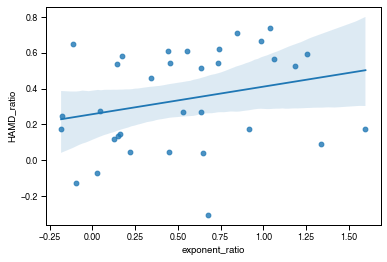

In [71]:
sns.regplot(ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['exponent_ratio']<3.0]['exponent_ratio'],
            ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['exponent_ratio']<3.0]['HAMD_ratio'])

In [72]:
formula = 'HAMD_ratio ~ exponent_ratio + ch_theta_perc + exponent_ratio:n_TxsReceived'

model = ols(formula, ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['exponent_ratio']<3.0]).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     1.778
Date:                Fri, 09 Dec 2022   Prob (F-statistic):              0.174
Time:                        14:47:38   Log-Likelihood:                -1.0093
No. Observations:                  32   AIC:                             10.02
Df Residuals:                      28   BIC:                             15.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

eval_env: 1


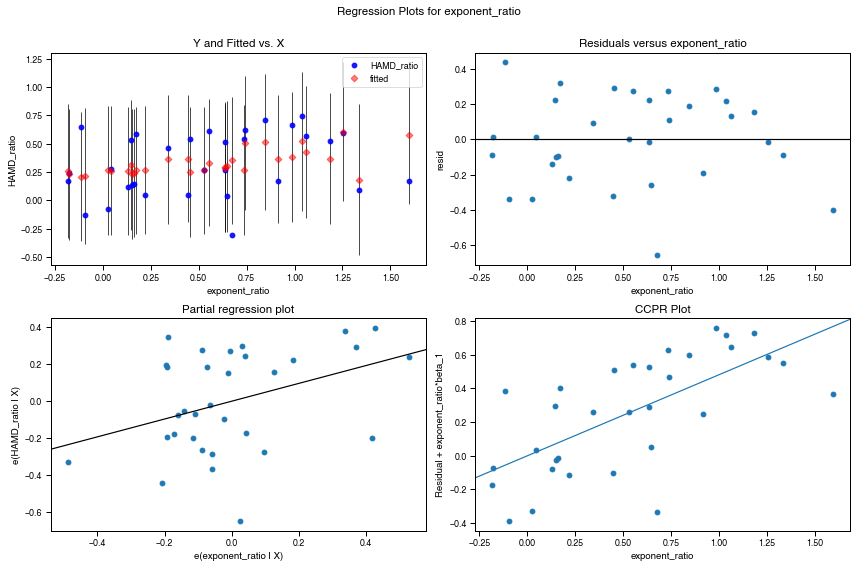

In [73]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'exponent_ratio', fig=fig)

# Plot Partial Regression (DIFFERENCE)

In [74]:
formula = 'HAMD_ratio ~ exponent:n_TxsReceived + exponent + ch_theta_perc'
model = ols(formula, ECT_MST_clin_eeg_diff)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     3.184
Date:                Fri, 09 Dec 2022   Prob (F-statistic):             0.0385
Time:                        14:47:38   Log-Likelihood:              -0.067293
No. Observations:                  33   AIC:                             8.135
Df Residuals:                      29   BIC:                             14.12
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [75]:
ECT_MST_clin_eeg_diff_nonan = pd.DataFrame(ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['HAMD_ratio'].notna()])
ECT_MST_clin_eeg_diff_nonan = pd.DataFrame(ECT_MST_clin_eeg_diff_nonan[ECT_MST_clin_eeg_diff_nonan['n_TxsReceived'].notna()])

eval_env: 1


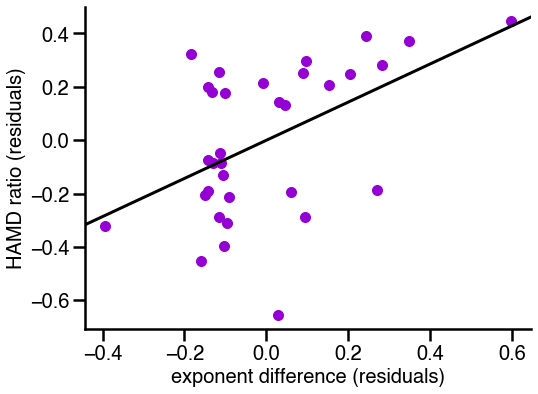

In [91]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.plot_partregress(endog="HAMD_ratio", exog_i="exponent", exog_others=["ch_theta_perc", "exponent:n_TxsReceived"], data=ECT_MST_clin_eeg_diff_nonan, obs_labels=False, color='darkviolet', ax=ax, markersize=10);
plt.xlabel('exponent difference (residuals)', size=20)
plt.ylabel('HAMD ratio (residuals)', size=20)
plt.title('', size=25)
ax.tick_params(axis='both', labelsize=20)
sns.despine()
plt.tight_layout()
plt.show()

# Plot Partial Regression (PRE)

In [77]:
formula = 'HAMD_ratio ~ exponent + ch_theta_perc '

model = ols(formula, ECT_MST_clin_eeg_pre).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.338
Date:                Fri, 09 Dec 2022   Prob (F-statistic):              0.113
Time:                        14:47:38   Log-Likelihood:                -2.4564
No. Observations:                  34   AIC:                             10.91
Df Residuals:                      31   BIC:                             15.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7210      0.189      3.815

In [78]:
ECT_MST_clin_eeg_pre_nonan = pd.DataFrame(ECT_MST_clin_eeg_pre[ECT_MST_clin_eeg_pre['HAMD_ratio'].notna()])

eval_env: 1


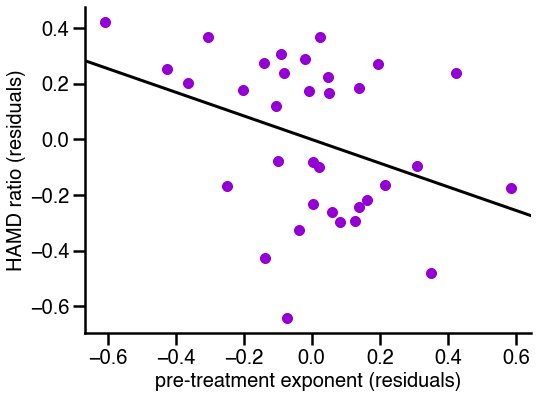

In [92]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.plot_partregress(endog="HAMD_ratio", exog_i="exponent", exog_others=["ch_theta_perc"], data=ECT_MST_clin_eeg_pre_nonan, obs_labels=False, color='darkviolet', ax=ax, markersize=10);
plt.xlabel('pre-treatment exponent (residuals)', size=20)
plt.ylabel('HAMD ratio (residuals)', size=20)
plt.title('', size=25)
ax.tick_params(axis='both', labelsize=20)
sns.despine()
plt.show()